In [47]:
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import pickle
from parameter_estimation import plot_parameter
from tracking import batch, track
from scipy.signal import savgol_filter

<Figure size 640x480 with 0 Axes>

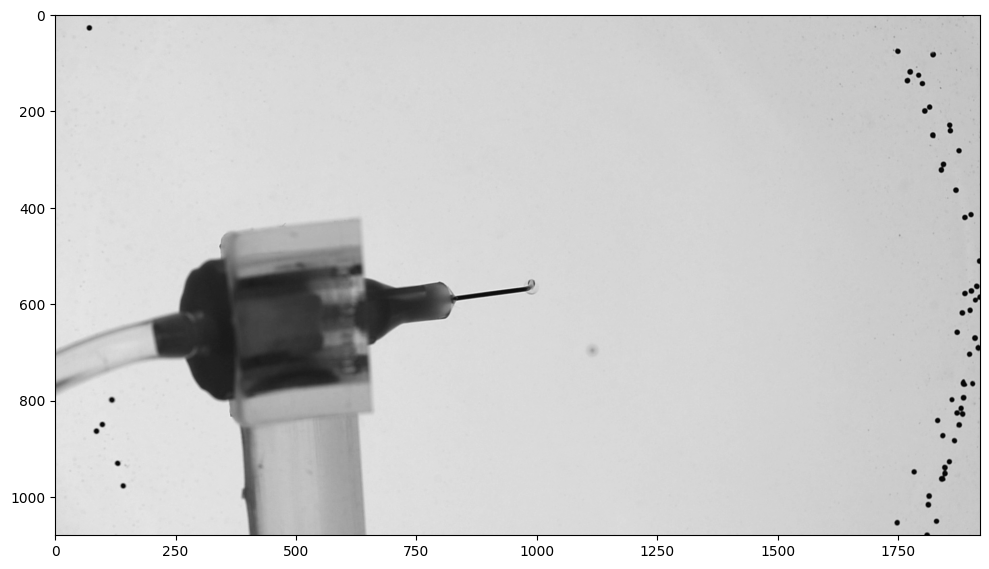

<Figure size 640x480 with 0 Axes>

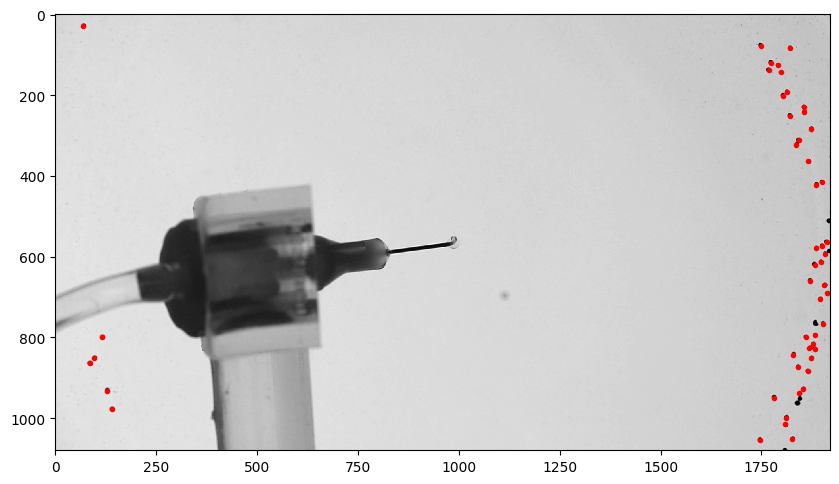

c:\Users\escud\Desktop\Marangoni\Code\marangoni-spreading\.venv\Lib\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


<Figure size 640x480 with 0 Axes>

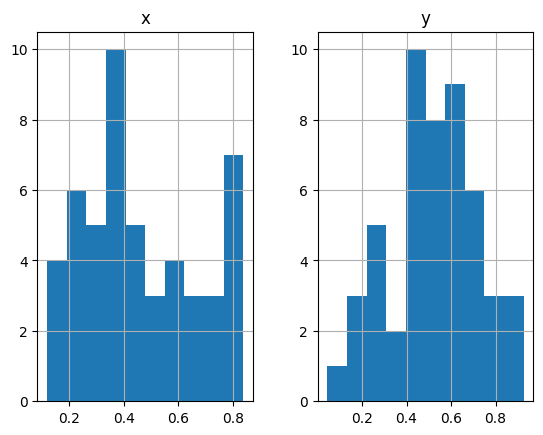

In [48]:
directory = "C:/Users/escud/Desktop/Marangoni/Videos/0306-Experiments/H=4cm_frames/"
last_frame = 400 # 455 is max for this video
diameter = 11
mass = 2600

frames = plot_parameter(directory, particle_diameter=diameter, particle_minmass=mass, frame_number=last_frame)

In [49]:
output_path = "C:/Users/escud/Desktop/Marangoni/Videos/0306-Experiments/H=4cm_frames_output/"
raw_frames = batch(frames[:last_frame], particle_diameter=diameter, particle_minmass=mass, save_video=False, output_path=output_path)

Frame 399: 50 features


Frame 399: 50 trajectories present.


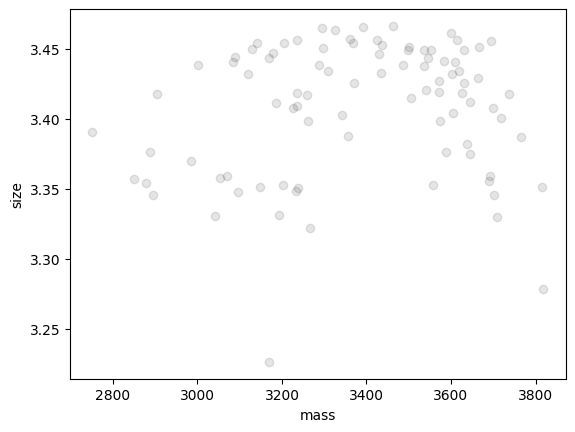

<Figure size 640x480 with 0 Axes>

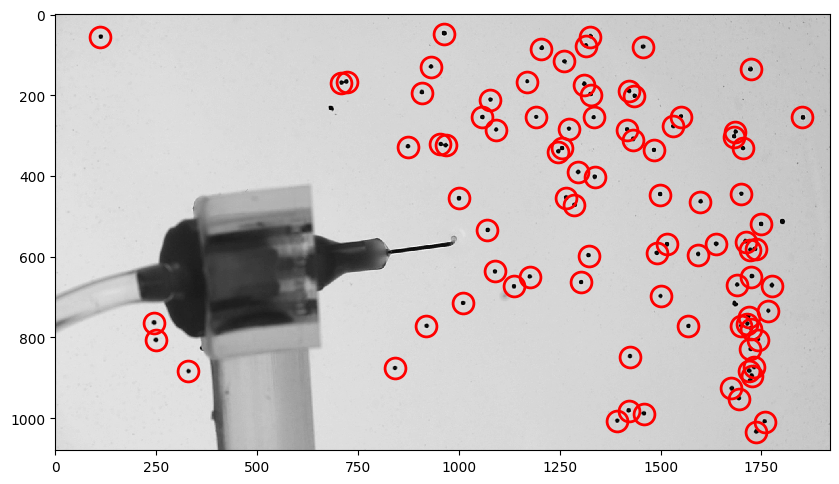

No-filter: 127
Pre-filter: 90
Filter: 90


In [50]:
status = False
filtered_trajectories = track(batched_frames=raw_frames, frames=frames[:last_frame], particle_diameter=diameter, particle_minmass=mass, filter_frame_number=100, save_video=status, output_path=output_path)

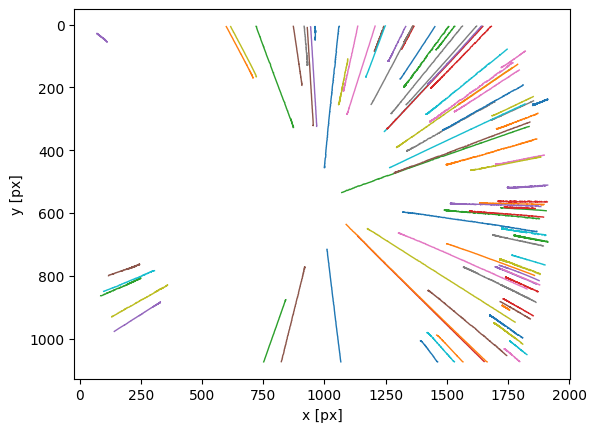

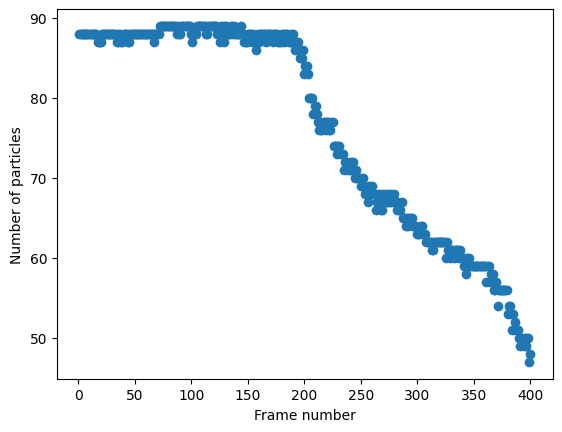

In [51]:
d = tp.compute_drift(filtered_trajectories)
tm = tp.subtract_drift(filtered_trajectories.copy(), d)
tm = filtered_trajectories ## ????
ax = tp.plot_traj(tm)
plt.show()

particles_per_frame = tm['frame'].value_counts().sort_index()
frame_number_array = np.linspace(1, len(particles_per_frame), len(particles_per_frame))
y_arr = tm['frame'].value_counts().sort_index()
plt.scatter(frame_number_array, y_arr)
plt.xlabel('Frame number')
plt.ylabel('Number of particles')

number_of_particles_max = max(particles_per_frame)

In [52]:
x_c = 988 # determine empirically with ImageJ
y_c = 558 # determine empirically with ImageJ

r_array_per_particle = []
for i in range(number_of_particles_max):
    interim = []
    for j in range(len(tm[tm['particle'] == i])):
        interim.append((np.sqrt((tm[tm['particle'] == i].iloc[j]['x'] - x_c)**2 + (tm[tm['particle'] == i].iloc[j]['y'] - y_c)**2), j))
    r_array_per_particle.append(interim)

In [53]:
print(len(r_array_per_particle))
for i in reversed(range(len(r_array_per_particle))):
    if len(r_array_per_particle[i]) == 0:
        r_array_per_particle.pop(i)
print(len(r_array_per_particle))

89
88


Total trajectories found: 88


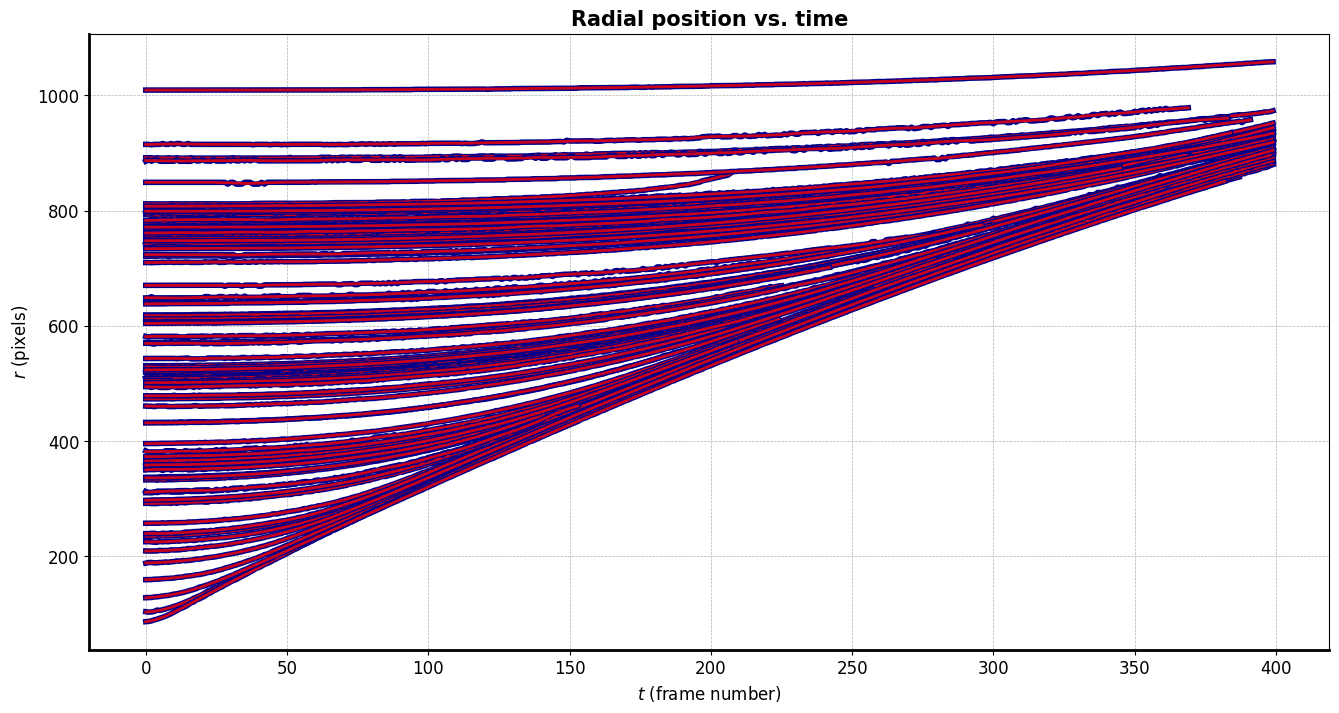

In [54]:

window_length = 21  # adjust to your data size
poly_order = 3


# Loop over each particle's data
plt.figure(figsize=(16, 8))
for i in range(len(r_array_per_particle)):
    x_array = [r_array_per_particle[i][j][1] for j in range(len(r_array_per_particle[i]))]
    y_array = [r_array_per_particle[i][j][0] for j in range(len(r_array_per_particle[i]))]
    x_array_smooth = savgol_filter(x_array, window_length, poly_order)
    y_array_smooth = savgol_filter(y_array, window_length, poly_order)
    plt.plot(x_array, y_array, label=f'Particle {i}', color="darkblue", alpha=1, linewidth=4)
    plt.plot(x_array_smooth, y_array_smooth, label=f'Particle {i} smooth', color="red", alpha=.8, linewidth=2)
    
plt.xlabel(r'$t$ (frame number)', fontsize=12)
plt.ylabel(r'$r$ (pixels)', fontsize=12)
plt.title('Radial position vs. time', fontsize=15, fontweight='bold')
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

print(f'Total trajectories found: {len(r_array_per_particle)}')

In [55]:
speed_array_per_particle = []
for i in range(len(r_array_per_particle)):
    time = [r_array_per_particle[i][j][-1] for j in range(len(r_array_per_particle[i]))]
    position = [r_array_per_particle[i][j][0] for j in range(len(r_array_per_particle[i]))]
    position_smooth = savgol_filter(position, window_length, poly_order)
    time_smooth = savgol_filter(time, window_length, poly_order)
    speed = np.diff(position_smooth) / np.diff(time_smooth)

    window_length = 50
    poly_order = 3
    speed_smooth = savgol_filter(speed, window_length, poly_order)

    interim = []
    for j in range(len(speed_smooth)):
        interim.append((speed_smooth[j], position[j + 1], time[j + 1]))
    speed_array_per_particle.append(interim)

In [56]:
speed_array_per_time = []

def speed_per_time(speed_array):
    for i in range(1, last_frame + 1):
        interim = []
        for j in speed_array:
            for k in j:
                if k[-1] == i:
                    interim.append(k)
        speed_array_per_time.append(interim)
    return speed_array_per_time
    
speed_array_per_time = speed_per_time(speed_array_per_particle)

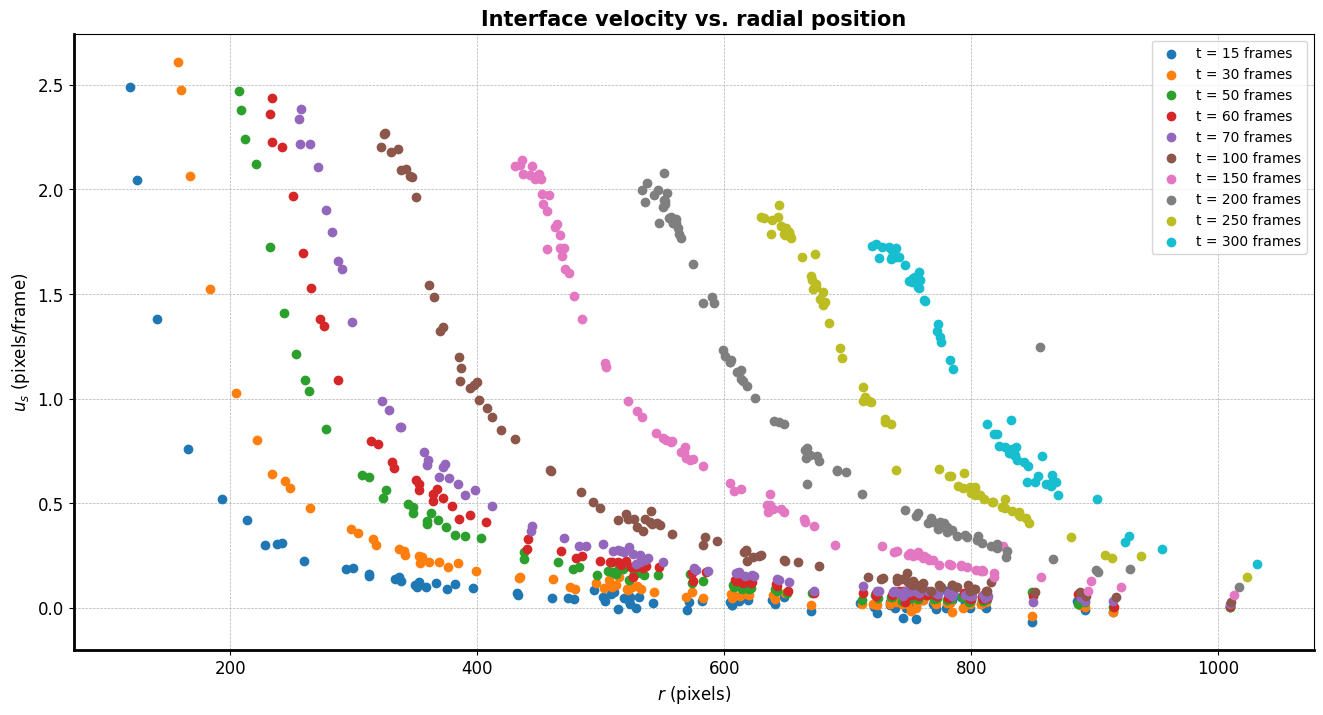

In [57]:
selection = [15, 30, 50, 60, 70, 100, 150, 200, 250, 300]
plt.figure(figsize=(16, 8))
for i in selection:
    surface_velocity = [speed_array_per_time[i][j][0] for j in range(len(speed_array_per_time[i]))]
    surface_position = [speed_array_per_time[i][j][1] for j in range(len(speed_array_per_time[i]))]
    plt.scatter(surface_position, surface_velocity,  label='t = ' + str(i) + ' frames', zorder=2)
plt.legend()

plt.xlabel(r'$r$ (pixels)', fontsize=12)
plt.ylabel(r'$u_s$ (pixels/frame)', fontsize=12)
plt.title('Interface velocity vs. radial position', fontsize=15, fontweight='bold')
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)

# figure_directory = "C:/Users/escud/Desktop/Marangoni/Figures/D=9.5cm/H=4cm/"
# plt.savefig(figure_directory + "speed_vs_radius_88_particles.jpeg", dpi=500, format='jpeg')
plt.show()

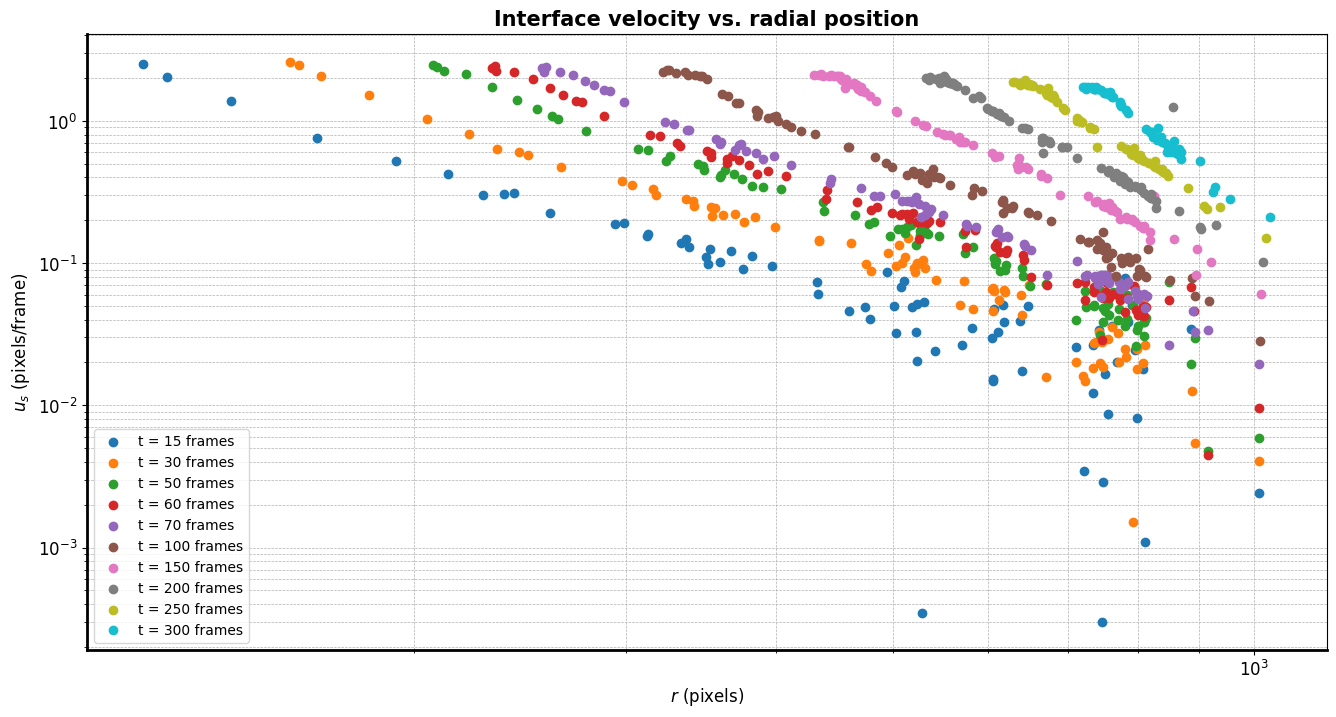

In [58]:
plt.figure(figsize=(16, 8))
for i in selection:
    surface_velocity = [speed_array_per_time[i][j][0] for j in range(len(speed_array_per_time[i]))]
    surface_position = [speed_array_per_time[i][j][1] for j in range(len(speed_array_per_time[i]))]
    plt.scatter(surface_position, surface_velocity,  label='t = ' + str(i) + ' frames', zorder=2)
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$ (pixels)', fontsize=12)
plt.ylabel(r'$u_s$ (pixels/frame)', fontsize=12)
plt.title('Interface velocity vs. radial position', fontsize=15, fontweight='bold')
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)

# figure_directory = "C:/Users/escud/Desktop/Marangoni/Figures/D=9.5cm/H=4cm/"
# plt.savefig(figure_directory + "log_speed_vs_radius_88_particles.jpeg", dpi=500, format='jpeg')
plt.show()

In [59]:
directory = 'C:/Users/escud/Desktop/Marangoni/Figures/D=9.5cm/H=4cm/' + 'speed_array_per_time_88_particles.pickle'
with open(directory, 'wb') as file:
    pickle.dump(speed_array_per_time, file)

directory = 'C:/Users/escud/Desktop/Marangoni/Figures/D=9.5cm/H=4cm/' + 'speed_array_per_particle_88_particles.pickle'
with open(directory, 'wb') as file:
    pickle.dump(speed_array_per_particle, file)